In [1]:
import torch
import time
import yaml
import random
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
sys.path.append('/home/yang_liu/python_workspace/3DGS')

import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import makedirs
from scene import Scene
from gaussian_renderer import render
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams

from scene.cameras import Camera
from utils.general_utils import PILtoTorch

WARNED = False

In [2]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def contract_to_unisphere(
        x: torch.Tensor,
        aabb: torch.Tensor,
        ord: float = 2,
        eps: float = 1e-6,
        derivative: bool = False,
    ):
        aabb_min, aabb_max = torch.split(aabb, 3, dim=-1)
        x = (x - aabb_min) / (aabb_max - aabb_min)
        x = x * 2 - 1  # aabb is at [-1, 1]
        mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
        mask = mag.squeeze(-1) > 1

        if derivative:
            dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
                1 / mag**3 - (2 * mag - 1) / mag**4
            )
            dev[~mask] = 1.0
            dev = torch.clamp(dev, min=eps)
            return dev
        else:
            x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
            x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
            return x

def loadCam(args, id, cam_info, resolution_scale, with_image=True):
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    loaded_mask = None
    resized_image_rgb = torch.zeros((3, resolution[1], resolution[0]), dtype=torch.float32)
    gt_image = torch.zeros((3, resolution[1], resolution[0]), dtype=torch.float32)
    if with_image:
        resized_image_rgb = PILtoTorch(cam_info.image, resolution)
        gt_image = resized_image_rgb[:3, ...]

        if resized_image_rgb.shape[1] == 4:
            loaded_mask = resized_image_rgb[3:4, ...]

    return Camera(colmap_id=cam_info.uid, R=cam_info.R, T=cam_info.T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

## 1. Render with render()

In [3]:
config = '../config/org_rubble_all.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)

config_name = os.path.splitext(os.path.basename(config))[0]
lp.model_path = os.path.join("../output/", config_name)

In [ ]:
with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    # lp.source_path = os.path.join("..", lp.source_path)
    lp.source_path = os.path.join("..", "data/mill19/rubble-pixsfm-2/train")
    # scene = Scene(lp, gaussians, load_iteration=iteration, shuffle=False)
    scene = Scene(lp, gaussians, shuffle=False)
    views = scene.getTestCameras()  # getTrainCameras, getTestCameras
    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

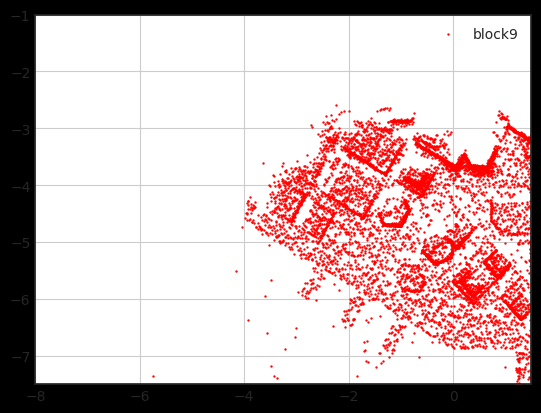

In [ ]:
plt.figure()
plt.style.use('seaborn-white')

plt.scatter(gaussians.get_xyz[::100, 0].detach().cpu(), gaussians.get_xyz[::100, 1].detach().cpu(), s=0.5, c='r', label='block9')
# plt.axis('equal')
plt.xlim(-8, 1.5)
plt.ylim(-7.5, -1)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
img_opt = 'points'  # 'depths', 'points'
with torch.no_grad():
    idx = random.randint(0, len(views)-1)
    view = views[idx]
    start = time.time()
    render_pkg = render(view, gaussians, pp, background)
    end = time.time()
    print("render time: {}s".format(end-start))
    image = render_pkg["render"].cpu().numpy().transpose(1,2,0)
    gt_image = view.original_image.cpu().numpy().transpose(1,2,0)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.axis(False)
plt.imshow(image)
plt.subplot(122)
plt.axis(False)
plt.imshow(gt_image)
plt.tight_layout()

## 2. Render with render_v2()

In [3]:
from scene.datasets import GSDataset
from scene import LargeScene
from gaussian_renderer import render_v2

### a. Render Mill19

In [56]:
config = '../config/block_campus_all_c36_loss_10.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
# lp.source_path = os.path.join("../", lp.source_path)
# lp.model_path = os.path.join("../output/", config_name)
# lp.pretrain_path = os.path.join("../", lp.pretrain_path)

# lp.block_id = 17
lp.source_path = os.path.join("../", "data/urban_scene_3d/campus-pixsfm/train")
lp.model_path = os.path.join("../output/", "block_campus_all_c36_loss_10")  # org_campus_all_lr4

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    # scene = LargeScene(lp, gaussians, shuffle=False)
    gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)
    print(f'Loaded {gaussians.get_xyz.shape[0]} Points\n')

Loading trained model at iteration 30000


Reading camera 5850/5850
Loaded 43248231 Points



In [57]:
from utils.loss_utils import l1_loss, ssim
from utils.sh_utils import SH2RGB

In [58]:
xy_range = [-325, -100, -300, 250, 900, 450]
block_dim = [6, 1, 6]

with torch.no_grad():
    xyz_org = gaussians.get_xyz
    aabb = torch.tensor(xy_range, device='cuda')
    xyz = contract_to_unisphere(xyz_org, aabb, ord=torch.inf)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


render time: 0.05808877944946289s


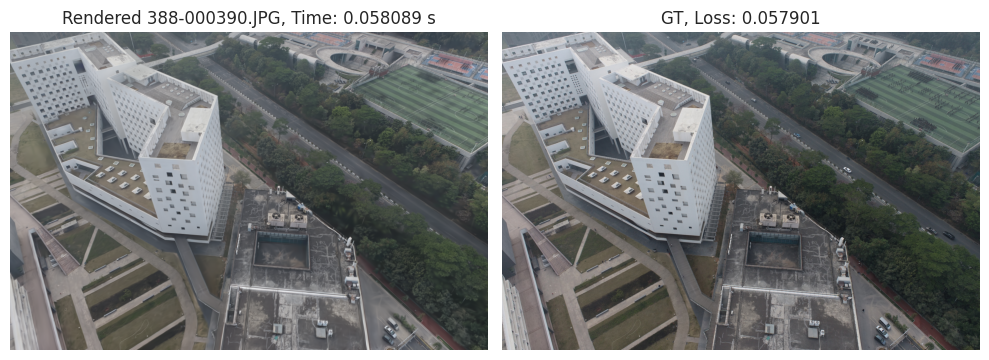

In [67]:
with torch.no_grad():
    # rubble
    # blur: 347, 559, 1364, 1464, 163, 1507, 1646

    # campus
    # low quality: 1267, 1963, 4362, 1669, 4070
    
    idx = random.randint(0, len(gs_dataset)-1)
    # idx = 2

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    cam_info, gt_image = gs_dataset[idx]
    image_name = os.path.split(gs_dataset.cameras[idx].image_path)[1]
    start = time.time()
    render_pkg = render_v2(cam_info, gaussians, pp, background)
    end = time.time()
    print("render time: {}s".format(end-start))
    render_image = render_pkg["render"]
    gt_image = gt_image.cuda()
    Ll1 = l1_loss(render_image, gt_image)
    loss = (1.0 - op.lambda_dssim) * Ll1 + op.lambda_dssim * (1.0 - ssim(render_image, gt_image))

    render_image = render_image.cpu().numpy().transpose(1,2,0)
    gt_image = gt_image.cpu().numpy().transpose(1,2,0)

    # points = gaussians.get_xyz
    # image_height = cam_info["image_height"]
    # image_width = cam_info["image_width"]
    # points_homo = torch.cat([points, torch.ones_like(points[..., [0]])], dim=-1)
    # points_screen = points_homo @ cam_info["full_proj_transform"]
    # points_screen = points_screen / points_screen[..., [-1]]
    # points_screen = points_screen[..., :-1]

    # mask = ((points_screen[..., 0] > -1) & (points_screen[..., 0] < 1) & (points_screen[..., 1] > -1) & (points_screen[..., 1] < 1))
    
    # color = SH2RGB(gaussians.get_features[mask, 0, :]).cpu().numpy()
    # color = (color - color.min(axis=0)) / (color.max(axis=0) - color.min(axis=0))
    # points_screen_x = ((points_screen[mask, 0] + 1.0) * image_width - 1.0) * 0.5
    # points_screen_y = ((points_screen[mask, 1] + 1.0) * image_height - 1.0) * 0.5

    # show render results
    plt.figure(figsize=(10, 10))
    plt.style.use('seaborn-white')
    plt.subplot(121)
    plt.axis(False)
    plt.imshow(render_image)
    # plt.imshow(empty_image)
    # plt.scatter(points_screen_x.cpu(), points_screen_y.cpu(), c=color, s=0.01)
    plt.title(f"Rendered {idx}-{image_name}, Time: {end - start:4f} s")
    plt.subplot(122)
    plt.axis(False)
    plt.imshow(gt_image)
    plt.tight_layout()
    plt.title(f'GT, Loss: {loss.item():4f}')

    # show visible points
    # plt.figure()
    # plt.style.use('seaborn-white')
    # visibility_filter = render_pkg["visibility_filter"].cpu().numpy()
    # plt.scatter(xyz[::200, 0].detach().cpu(), xyz[::200, 2].detach().cpu(), s=0.5, c='r', label='orginal')
    # plt.scatter(xyz[visibility_filter][::200, 0].detach().cpu(), xyz[visibility_filter][::200, 2].detach().cpu(), s=0.5, c='g', label='visible')
    # # plt.xlim(-11, 11)
    # # plt.ylim(-8, 7)
    # # plt.xticks(np.linspace(0,1,block_dim[0]+1,endpoint=True))
    # # plt.yticks(np.linspace(0,1,block_dim[2]+1,endpoint=True))
    # plt.legend()
    # plt.grid(True)
    # plt.show()

### a.1 Check training data

In [8]:
config = '../config/block_campus_all_c36_loss_10_lr2.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
# lp.source_path = os.path.join("../", lp.source_path)
# lp.model_path = os.path.join("../output/", config_name)
# lp.pretrain_path = os.path.join("../", lp.pretrain_path)

# lp.block_id = 17
lp.source_path = os.path.join("../", "data/urban_scene_3d/campus-pixsfm/val")
lp.model_path = os.path.join("../output/", f"block_campus_all_c36_loss_10_lr2_cell17")  # org_campus_all_lr4

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    # scene = LargeScene(lp, gaussians, shuffle=False)
    gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)
    print(f'Loaded {gaussians.get_xyz.shape[0]} Points\n')

Loading trained model at iteration 30000
Reading camera 21/21
Loaded 10935675 Points



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


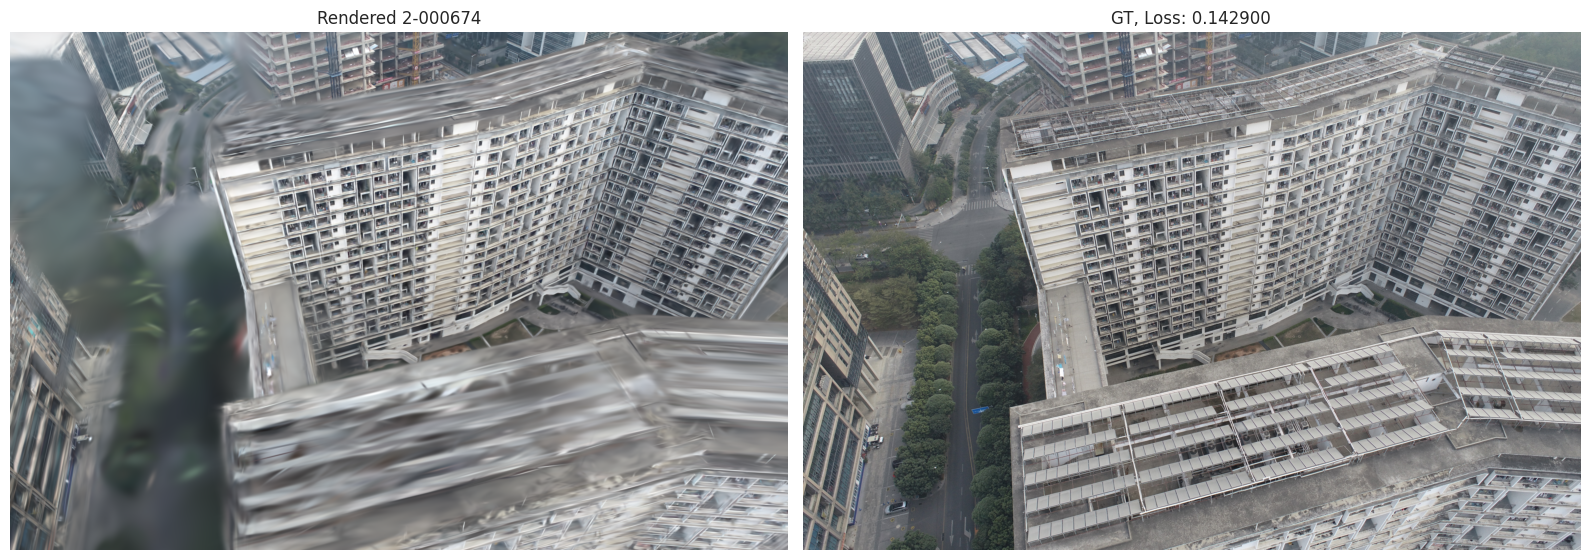

In [10]:
from torch.utils.data import DataLoader
from utils.loss_utils import l1_loss, ssim
from utils.sh_utils import SH2RGB

with torch.no_grad():
    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    data_loader = DataLoader(gs_dataset, batch_size=1, shuffle=False, num_workers=0)
    for idx, (cam_info, gt_image) in enumerate(data_loader):
        if idx != 2:
            continue
        image_name = os.path.split(gs_dataset.cameras[idx].image_path)[1].split('.')[0]
        render_pkg = render_v2(cam_info, gaussians, pp, background)
        render_image = render_pkg["render"]
        gt_image = gt_image[0].cuda()
        Ll1 = l1_loss(render_image, gt_image)
        loss = (1.0 - op.lambda_dssim) * Ll1 + op.lambda_dssim * (1.0 - ssim(render_image, gt_image))

        render_image = render_image.cpu().numpy().transpose(1,2,0)
        gt_image = gt_image.cpu().numpy().transpose(1,2,0)

        # show render results
        plt.figure(figsize=(16, 8))
        plt.style.use('seaborn-white')
        plt.subplot(121)
        plt.axis(False)
        plt.imshow(render_image)
        plt.tight_layout()
        # plt.imshow(empty_image)
        # plt.scatter(points_screen_x.cpu(), points_screen_y.cpu(), c=color, s=0.01)
        plt.title(f"Rendered {idx}-{image_name}")
        plt.subplot(122)
        plt.axis(False)
        plt.imshow(gt_image)
        plt.tight_layout()
        plt.title(f'GT, Loss: {loss.item():4f}')
        if not os.path.exists(f'../output/vis/{config_name}_{lp.block_id}'):
            makedirs(f'../output/vis/{config_name}_{lp.block_id}')
        plt.savefig(f'../output/vis/{config_name}_{lp.block_id}/{image_name}.png', facecolor="w")
        plt.close()

### b. Render MatrixCity

In [30]:
config = '../config/block_mc_aerial_block_all_lr_c36_loss_5.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
# lp.source_path = os.path.join("../", lp.source_path)
# lp.model_path = os.path.join("../output/", config_name)
# lp.pretrain_path = os.path.join("../", lp.pretrain_path)

# lp.block_id = 16
lp.source_path = os.path.join("../", "data/matrix_city/aerial/train/block_all")
lp.model_path = os.path.join("../output/", "block_mc_aerial_block_all_lr_c36_loss_5")

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    # scene = LargeScene(lp, gaussians, shuffle=False)
    gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)
    print(f'Loaded {gaussians.get_xyz.shape[0]} Points\n')

Loading trained model at iteration 30000
Reading camera 5621/5621
Loaded 23565603 Points



In [31]:
xy_range = [-3.5, -4, 4.5, 2]
block_dim = [6, 6, 1]

with torch.no_grad():
    xyz_org = gaussians.get_xyz
    aabb = torch.tensor([xy_range[0], xy_range[1], xyz_org[:, -1].min(), 
                        xy_range[2], xy_range[3], xyz_org[:, -1].max()], device='cuda')
    xyz = contract_to_unisphere(xyz_org, aabb, ord=torch.inf)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


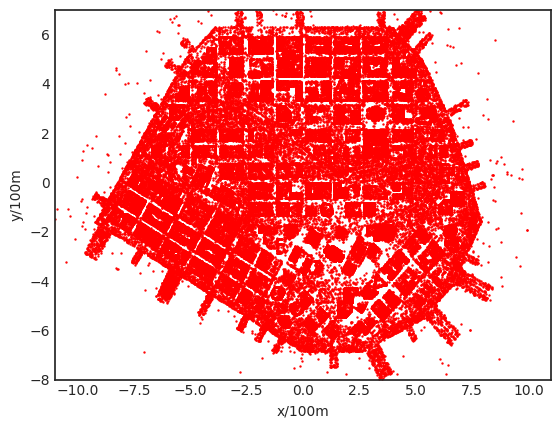

In [33]:
plt.figure()
plt.style.use('seaborn-white')
plt.scatter(xyz_org[::200, 0].detach().cpu(), xyz_org[::200, 1].detach().cpu(), s=0.5, c='r')
plt.xlim(-11, 11)
plt.ylim(-8, 7)
plt.xlabel('x/100m')
plt.ylabel('y/100m')
# plt.plot([xy_range[0], xy_range[0]], [xy_range[1], xy_range[3]], 'b')
# plt.plot([xy_range[2], xy_range[2]], [xy_range[1], xy_range[3]], 'b')
# plt.plot([xy_range[0], xy_range[2]], [xy_range[1], xy_range[1]], 'b')
# plt.plot([xy_range[0], xy_range[2]], [xy_range[3], xy_range[3]], 'b')
plt.legend()
# plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


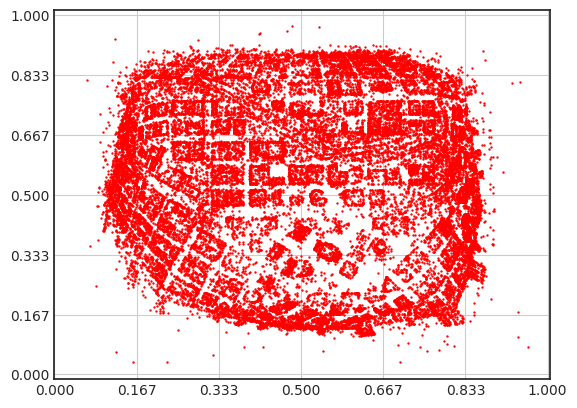

In [25]:
plt.figure()
plt.style.use('seaborn-white')
visibility_filter = render_pkg["visibility_filter"].cpu().numpy()
plt.scatter(xyz[::200, 0].detach().cpu(), xyz[::200, 1].detach().cpu(), s=0.5, c='r')
plt.xticks(np.linspace(0,1,block_dim[0]+1,endpoint=True))
plt.yticks(np.linspace(0,1,block_dim[1]+1,endpoint=True))
plt.legend()
plt.grid(True)
plt.show()

[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1
render time: 0.018201351165771484s


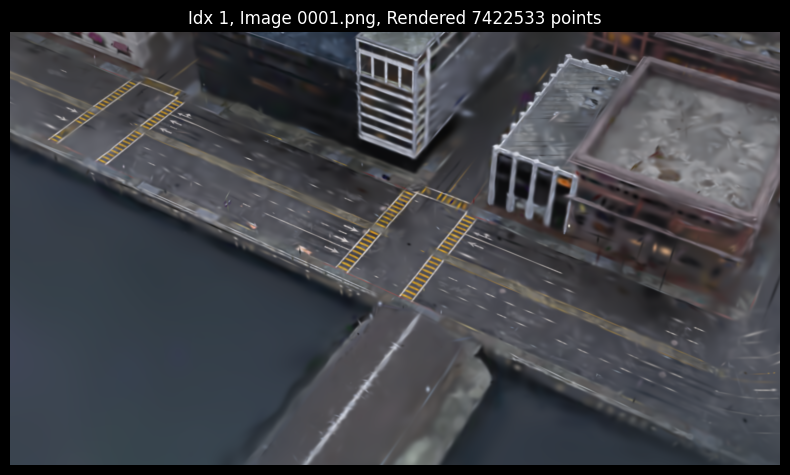

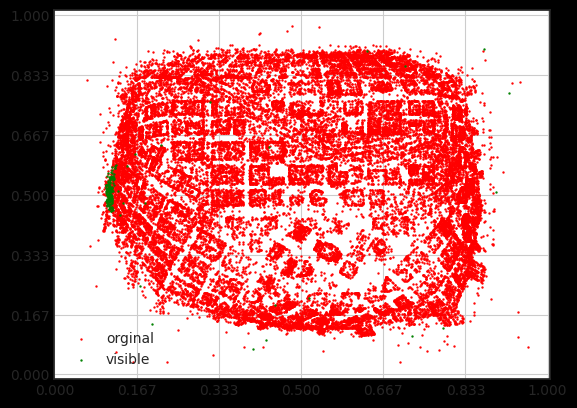

In [7]:
with torch.no_grad():
    # range free for block 9
    # interplay: 1517, 1114, 1538, 884, 849, 1535, 1532, 1264, 106, 99, 55
    # low quality: 1148, 916, 1560, 907

    # range free for block all
    # interplay: 
    # low quality: 101
    idx = random.randint(0, len(gs_dataset)-1)
    idx = 1

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    cam_info, gt_image = gs_dataset[idx]
    image_name = os.path.split(gs_dataset.cameras[idx].image_path)[1]
    start = time.time()
    render_pkg = render_v2(cam_info, gaussians, pp, background)
    end = time.time()
    print("render time: {}s".format(end-start))
    image = render_pkg["render"]

    image = image.cpu().numpy().transpose(1,2,0)

    # show render results
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Idx {idx}, Image {image_name}, Rendered {render_pkg['radii'].shape[0]} points")
    plt.axis(False)
    plt.tight_layout()
    plt.show()

    # show visible points
    plt.figure()
    plt.style.use('seaborn-white')
    visibility_filter = render_pkg["visibility_filter"].cpu().numpy()
    plt.scatter(xyz[::200, 0].detach().cpu(), xyz[::200, 1].detach().cpu(), s=0.5, c='r', label='orginal')
    plt.scatter(xyz[visibility_filter][::200, 0].detach().cpu(), xyz[visibility_filter][::200, 1].detach().cpu(), s=0.5, c='g', label='visible')
    # plt.xlim(-11, 11)
    # plt.ylim(-8, 7)
    plt.xticks(np.linspace(0,1,block_dim[0]+1,endpoint=True))
    plt.yticks(np.linspace(0,1,block_dim[1]+1,endpoint=True))
    plt.legend()
    plt.grid(True)
    plt.show()